In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  #To not print info mesages
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.set_floatx('float32')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#---Custom Functions --------------------------------------------------------------------------------------------------------
def create_set(limits, data, b_s):
    i_min, i_max = limits
    new_set = []
    for i in range(i_min, i_max, b_s):
        new_set.append(data[i : i+b_s])
    return new_set

#---Model--------------------------------------------------------------------------------------------------------------------
class MyModel(tf.keras.Model):                          #Make the thing
    def __init__(self, kernels, filters):               #Put smaller things in it
        super(MyModel, self).__init__(name="basicCNN")
        kernel1, kernel2, kernel3, kernel4 = kernels             #Decide the shape of the smaller things
        filter1, filter2, filter3, filter4 = filters             #Decide how many there are

        self.conv2a = tf.keras.layers.Conv2D(filter1, kernel1, padding='same')  #Now stack'em 
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.Activation(tf.nn.relu)                      #Non-lin otherwhise you just compute f(x)=W.x
        self.mxpool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid')  #Now shrink the thingy

        self.conv2b = tf.keras.layers.Conv2D(filter2, kernel2, padding='same')  #And again
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation(tf.nn.relu)
        self.mxpool2 = tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid')

        self.conv2c = tf.keras.layers.Conv2D(filter3, kernel3, padding='same')  #And again
        self.bnorm3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.Activation(tf.nn.relu)
        self.mxpool3 = tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid')

        self.conv2d = tf.keras.layers.Conv2D(filter4, kernel4, padding='same')  #And again
        self.bnorm4 = tf.keras.layers.BatchNormalization()
        self.act4 = tf.keras.layers.Activation(tf.nn.relu)
        self.mxpool4 = tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'valid')

        self.flat = tf.keras.layers.Flatten()           #Now decide what it is you are actually looking at
        self.FC1 = tf.keras.layers.Dense(64)
        self.FCo = tf.keras.layers.Dense(10)

    def call(self, input, training=False):
        x = self.conv2a(input)
        x = self.bnorm1(x)
        x = self.act1(x)
        x = self.mxpool1(x)

        x = self.conv2b(x)
        x = self.bnorm2(x)
        x = self.act2(x)
        x = self.mxpool2(x)

        x = self.conv2c(x)
        x = self.bnorm3(x)
        x = self.act3(x)
        x = self.mxpool3(x)

        x = self.conv2d(x)
        x = self.bnorm4(x)
        x = self.act4(x)
        x = self.mxpool4(x)

        x = self.flat(x)
        x = self.FC1(x)
        x = self.FCo(x)
        return x


In [2]:
#---Data Preprocessing-------------------------------------------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data() #import dataset
x_train, x_test = x_train / 255.0, x_test / 255.0       #Normalization pixels

rng_state = np.random.get_state()
np.random.shuffle(x_train)                     #Shuffle it before making train and val sets
np.random.set_state(rng_state)
np.random.shuffle(y_train)

x_train = x_train[..., tf.newaxis].astype("float32")    #Add an axis for the single channel
x_test = x_test[..., tf.newaxis].astype("float32")
x_val = x_train[-10000:]            #Validation set
y_val = y_train[-10000:]
x_train = x_train[:-10000]          #Cut it from the training set
y_train = y_train[:-10000]

y_train = tf.keras.backend.one_hot(y_train, 10)
y_val = tf.keras.backend.one_hot(y_val, 10)
y_test = tf.keras.backend.one_hot(y_test, 10)

x_val -= np.mean(np.mean(x_train.reshape(50000,784), axis=1), axis=0)   #Substract mean image
x_test -= np.mean(np.mean(x_train.reshape(50000,784), axis=1), axis=0)
x_train -= np.mean(np.mean(x_train.reshape(50000,784), axis=1), axis=0)

x_train_dataset = create_set((0, 50000), x_train, 32)
y_train_dataset = create_set((0, 50000), y_train, 32)
train_dataset = []

for i in range(len(x_train_dataset)):
    train_dataset.append( (x_train_dataset[i], y_train_dataset[i]) )

x_val_dataset = create_set((0, 10000), x_val, 32)
y_val_dataset = create_set((0, 10000), y_val, 32)
val_dataset = []

x_test_dataset = create_set((0, 10000), x_test, 32)
y_test_dataset = create_set((0, 10000), y_test, 32)
test_dataset = []

for i in range(len(x_val_dataset)):
    val_dataset.append( (x_val_dataset[i], y_val_dataset[i]) )
    test_dataset.append( (x_test_dataset[i], y_test_dataset[i]) )

In [60]:
#---Variables----------------------------------------------------------------------------------------------------------------
batch_size = 32
num_epochs = 5
kernels = [(4,4), (4,4), (4,4), (4,4)]
filters = [16, 32, 64, 128]

LR_list = [
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=200, decay_rate=0.93),
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=200, decay_rate=0.90),
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.93),
]

3


In [63]:
min_train_loss = []
min_val_loss = []
max_val_acc = []

for learning_rate in LR_list:
    model = MyModel(kernels, filters)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

    train_loss_metric = keras.metrics.Mean()
    val_loss_metric = keras.metrics.Mean()
    accuracy_metric = keras.metrics.Sum()
    
    for j in range(5):
        print('START CNN training {} with learning rate = {}'.format(j+1, learning_rate))
        train_loss_list = []
        val_loss_list = []
        val_acc_list = []

        for epoch in range(num_epochs):
            print("Start of Epoch {}".format(epoch + 1))
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    tape.watch(model.trainable_weights)
                    predictions = model(x_batch_train, training=True)
                    batch_loss_value = loss_fn(y_batch_train, predictions)
                grads = tape.gradient(batch_loss_value, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                train_loss_metric.update_state(batch_loss_value)

                if step % 200 == 0:
                    val_loss_metric.reset_states()
                    accuracy_metric.reset_states()
                    for (x_batch_val, y_batch_val) in val_dataset:
                        val_pred = model(x_batch_val, training=False)
                        val_loss_metric.update_state( loss_fn(y_batch_val, val_pred) )
                        num_positive_class ,= np.where(np.argmax(val_pred, axis=1) == np.argmax(y_batch_val, axis=1))
                        accuracy_metric.update_state(num_positive_class.size)
                    
                    train_loss_list.append(train_loss_metric.result())
                    val_loss_list.append(test_loss_metric.result())
                    val_acc_list.append(accuracy_metric.result()/10000)

                    print(
                        "Step %d: Train loss: %.4f, Test loss: %.4f, Test Accuracy: %.4f"
                        % (
                            step,
                            float(train_loss_metric.result()), 
                            float(val_loss_metric.result()), 
                            float(accuracy_metric.result()/10000)
                        )
                    )
        min_train_loss.append(min(train_loss_list))
        min_val_loss.append(min(val_loss_list))
        max_val_acc.append(max(val_acc_list))
        print('END CNN training {} with learning rate = {}'.format(j+1, learning_rate))

loss: 0.1478, Test loss: 0.2456, Test Accuracy: 0.9192
Step 400: Train loss: 0.1475, Test loss: 0.2454, Test Accuracy: 0.9190
Step 600: Train loss: 0.1473, Test loss: 0.2456, Test Accuracy: 0.9189
Step 800: Train loss: 0.1471, Test loss: 0.2456, Test Accuracy: 0.9190
Step 1000: Train loss: 0.1468, Test loss: 0.2453, Test Accuracy: 0.9194
Step 1200: Train loss: 0.1465, Test loss: 0.2453, Test Accuracy: 0.9188
Step 1400: Train loss: 0.1463, Test loss: 0.2455, Test Accuracy: 0.9191
END CNN training 4 with learning rate = <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.ExponentialDecay object at 0x000001B0A4B9C6D0>
START CNN training 5 with learning rate = <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.ExponentialDecay object at 0x000001B0A4B9C6D0>
Start of Epoch 1
Step 0: Train loss: 0.1461, Test loss: 0.2455, Test Accuracy: 0.9188
Step 200: Train loss: 0.1459, Test loss: 0.2456, Test Accuracy: 0.9192
Step 400: Train loss: 0.1456, Test loss: 0.2454, Test Accurac

In [67]:
for i in range(len(min_train_loss)):
    min_train_loss[i] = min_train_loss[i].numpy()
    min_val_loss[i] = min_val_loss[i].numpy()
    max_val_acc[i] = max_val_acc[i].numpy()

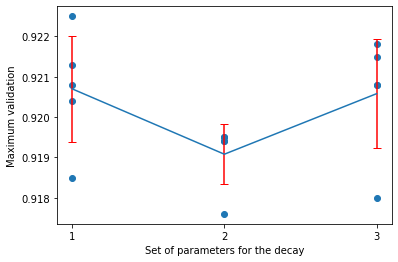

In [79]:
x_vec = np.ones(5)
x_vec2 = np.ones(5)*2
x_vec3 = np.ones(5)*3

x_ax = list(x_vec) + list(x_vec2) + list(x_vec3)

y_means = np.zeros(3)
y_var = np.zeros(3)

for i in range(0,15,5):
    y_means[int(i/5)] = np.mean( max_val_acc[i : i+5])
    y_var[int(i/5)] = np.var( max_val_acc[i : i+5] )

plt.scatter(x_ax, max_val_acc)
plt.errorbar([1, 2, 3], y_means, yerr=np.sqrt(y_var), ecolor="r", capsize=4)
plt.xlabel("Set of parameters for the decay")
plt.ylabel("Maximum validation")
plt.xticks([1,2,3])
plt.show()

In [64]:
print(len(x_ax))

20
